# Muhammad Ehtesham 24k-7316

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [2]:
# Step 1: Load and Prepare Data
df = pd.read_excel("06Sales_Volume_New.xlsx", sheet_name="_SalV")
df = df.iloc[1:].copy()
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)
sales_df = df.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')

# Clean and convert month headers to datetime
new_cols = pd.to_datetime([c.replace("'", " 20") if isinstance(c, str) else c for c in sales_df.columns], errors='coerce')
sales_df.columns = new_cols

# Total monthly sales across all variants
monthly_sales = sales_df.sum(axis=0).sort_index()

In [7]:
# Step 2: Prepare Data for Neural Network
window_size = 6  # use past 6 months to predict next
X, y = [], []

for i in range(len(monthly_sales) - window_size):
    X.append(monthly_sales[i:i+window_size].values)
    y.append(monthly_sales[i+window_size])

X = np.array(X)
y = np.array(y)

# Use separate scalers for input and output
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

X_scaled = input_scaler.fit_transform(X)
y_scaled = output_scaler.fit_transform(y.reshape(-1, 1))

<ipython-input-7-bca593dead6d>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(monthly_sales[i+window_size])


In [8]:
# Step 3: Build and Train the Neural Network
model = Sequential([
    Dense(64, activation='relu', input_shape=(window_size,)),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_scaled, y_scaled, epochs=200, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Step 4: Forecast Feb 2025 – July 2025
future_preds = []
last_window = monthly_sales[-window_size:].values

for _ in range(6):
    input_scaled = input_scaler.transform(last_window.reshape(1, -1))
    pred_scaled = model.predict(input_scaled)[0][0]
    pred = output_scaler.inverse_transform([[pred_scaled]])[0][0]
    future_preds.append(pred)

    last_window = np.append(last_window[1:], pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


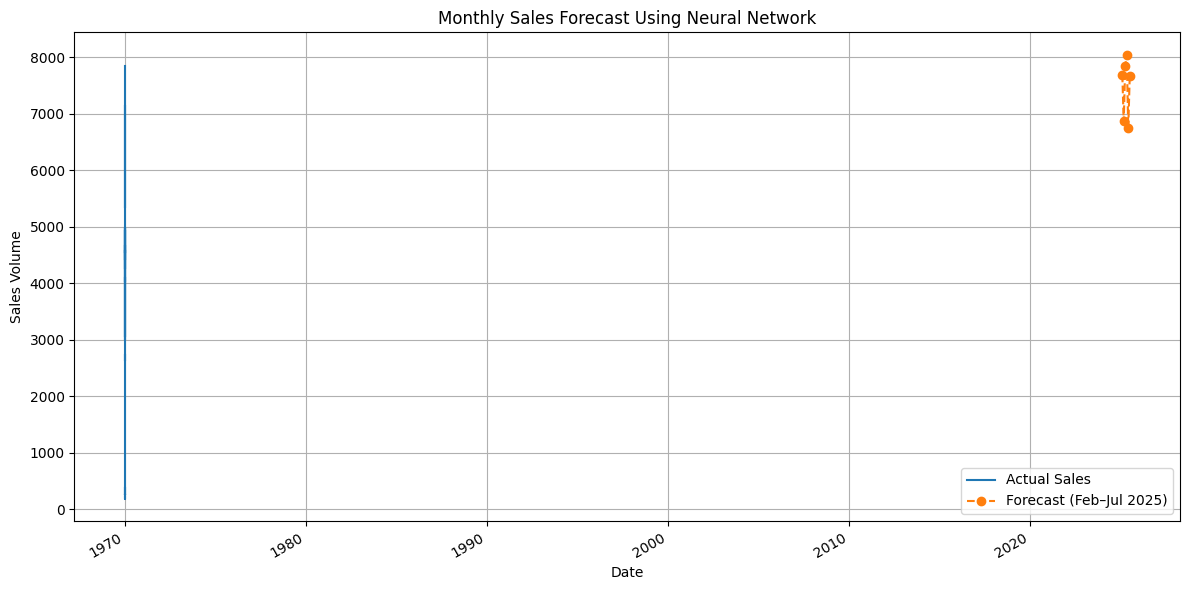

In [10]:
# Step 5: Plot Results
forecast_dates = pd.date_range(start="2025-02-01", periods=6, freq='MS')
forecast_series = pd.Series(future_preds, index=forecast_dates)

plt.figure(figsize=(12, 6))
monthly_sales.plot(label='Actual Sales')
forecast_series.plot(label='Forecast (Feb–Jul 2025)', linestyle='--', marker='o')
plt.title("Monthly Sales Forecast Using Neural Network")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Step 6: Print Forecasted Values
print("\n📈 Forecasted Sales (Feb 2025 – Jul 2025):\n")
print(forecast_series.round(2))


📈 Forecasted Sales (Feb 2025 – Jul 2025):

2025-02-01    7691.03
2025-03-01    6862.01
2025-04-01    7837.85
2025-05-01    8045.27
2025-06-01    6737.70
2025-07-01    7669.18
Freq: MS, dtype: float64
